# Gathering and preprocessing



In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import colorsys

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



#### Combine the data

In [2]:
files = [file for file in os.listdir("./LGA_data") if file.endswith(".xls")]
all_files = pd.DataFrame()

for file in files:
    df = pd.read_excel("./LGA_data/" + file)
    all_files = pd.concat([all_files, df])

#### Clean the data

In [3]:
num_rows = all_files.shape[0]
print("Number of rows before cleaning:", num_rows)
all_files.dropna(subset=['Street Display'], inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping NAs:", num_rows)
all_files.drop_duplicates(inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping duplicates:", num_rows)
# Find the indices of the rows with sale price equal to 0
indices_to_drop = all_files[all_files['Sale Price'] == 0].index
# Drop the rows from the dataset
all_files.drop(indices_to_drop, inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping obs with sales price = 0:", num_rows)


Number of rows before cleaning: 874193
Number of rows after dropping NAs: 873680
Number of rows after dropping duplicates: 873610
Number of rows after dropping obs with sales price = 0: 526056


In [4]:
all_files = all_files.reset_index(drop=True)
df = all_files
# df.to_csv('alldata.csv', index=False)

#### Check the data

In [5]:
# Check if all LGAs have sale data from 1/7/2018 to 1/7/2023
# oldest_sale_dates = df.groupby('LGA')['Sale Date'].min()
# print(oldest_sale_dates)
# oldest_sale_dates.to_csv('oldest_sale_dates.csv')

When downloading the data, I noticed that there would be a maximum of 10,000 observations downloaded for each LGA. I want to investigate whether there is a gap of sales data in those LGAs from 01/07/2018 to 01/07/2023. I will need to download more data for these LGAs. Below I find at what date I should re-download data.

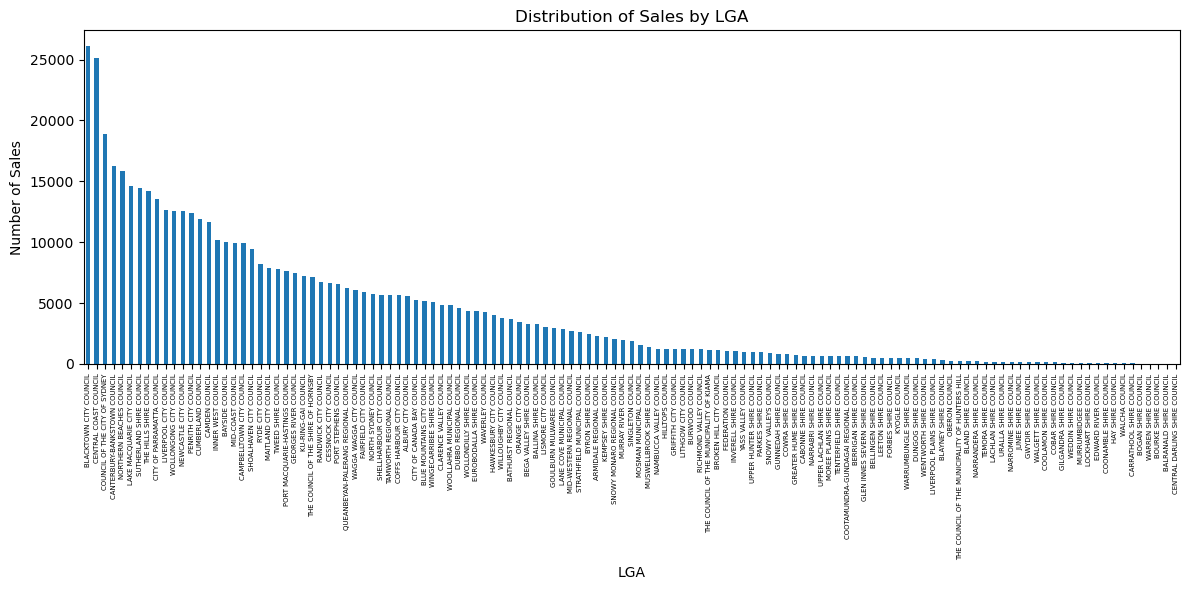

LGAs with 10,000 sales, latest sale dates, and Street Display:


In [6]:
# Group the data by LGA and count the number of sales
sales_count_by_lga = df['LGA'].value_counts()

# Plot the distribution graph
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sales_count_by_lga.plot(kind='bar')
plt.xlabel('LGA')
plt.ylabel('Number of Sales')
plt.title('Distribution of Sales by LGA')
plt.xticks(rotation=90, fontsize=5)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust the layout
plt.show()

# Filter LGAs with 10,000 sales
lgas_with_10000_sales = sales_count_by_lga[sales_count_by_lga == 10000]

# Print the names of LGAs with 10,000 sales
print("LGAs with 10,000 sales, latest sale dates, and Street Display:")
for lga in lgas_with_10000_sales.index:
    lga_data = df[df['LGA'] == lga]
    latest_sale_date = lga_data['Sale Date'].max()
    latest_sale_street_display = lga_data.loc[lga_data['Sale Date'] == latest_sale_date, 'Street Display'].iloc[0]
    print(f"LGA: {lga}, Latest Sale Date: {latest_sale_date}, Street Display: {latest_sale_street_display}")

In [7]:
# lga_specific_sales = df[df['LGA'] == 'RYDE CITY COUNCIL']
# lga_specific_sales.head(30)


Now I'll check to see if the data looks right and makes sense

In [8]:
df.columns

Index(['Disclaimer', 'Building Name', 'Street Display',
       'Alternate Street Display', 'Other', 'Unit', 'Number', 'Street Name',
       'Locality', 'Postcode', 'Alt. Street', 'Alt. Locality',
       'Legal Description', 'Volume/Folio', 'Vendor Names', 'Vendor Address',
       'Purchaser Names', 'Purchaser Address', 'Volume Folio', 'Parish',
       'Office Name', 'Agent Name', 'First Price', 'Change %', 'Last Price',
       'Change %.1', 'Days To Sell', 'Sale Price', 'Sale Date',
       'Settlement Date', 'Sale Type', 'Area', 'Building Area', 'Bedrooms',
       'Bathrooms', 'Car Parks', 'Property Type', 'Land Use', 'Zoning',
       'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type',
       'Roof Type', 'Improvements', 'Hundred', 'Sale Category',
       'Document Status', 'Parties Related Flag', 'Parties Related',
       'Valuation Date', 'Valuation Amount', 'LGA', 'Dealing Number',
       'Government Number', 'Parent Government Number', 'PDS ID', 'Sale ID',
       

In [9]:
df.dtypes

Disclaimer                          object
Building Name                       object
Street Display                      object
Alternate Street Display           float64
Other                              float64
Unit                               float64
Number                              object
Street Name                         object
Locality                            object
Postcode                           float64
Alt. Street                        float64
Alt. Locality                      float64
Legal Description                   object
Volume/Folio                       float64
Vendor Names                        object
Vendor Address                      object
Purchaser Names                     object
Purchaser Address                   object
Volume Folio                       float64
Parish                             float64
Office Name                         object
Agent Name                          object
First Price                         object
Change %   

In [10]:
# Calculate summary statistics for numeric columns
summary_stats = df[['Sale Price', 'Area', 'Bedrooms', 'Bathrooms', 'Car Parks']].describe()

# Print the summary statistics
print(summary_stats)


         Sale Price          Area       Bedrooms      Bathrooms      Car Parks
count  5.260560e+05  5.029530e+05  392689.000000  392470.000000  374149.000000
mean   1.096319e+06  4.918656e+04       3.159192       1.737521       1.968459
std    4.943911e+06  1.511399e+06       1.515466       1.588563       4.474361
min    1.000000e+03  7.892128e-01       0.000000       0.000000       0.000000
25%    4.710000e+05  4.201000e+02       2.000000       1.000000       1.000000
50%    7.190000e+05  6.620000e+02       3.000000       2.000000       2.000000
75%    1.125108e+06  1.112597e+03       4.000000       2.000000       2.000000
max    9.459457e+08  4.553400e+08     400.000000     815.000000    1200.000000


Weird that theres a property with 400 bedrooms. Same weirdness with 815 bathrooms and 1619 car parks.

Even more weird that there's a sale for $945M.

# Analysis

### Box and whisker plots

I'll use box and whisker plots to show the mean and interquartile range differences between each LGA

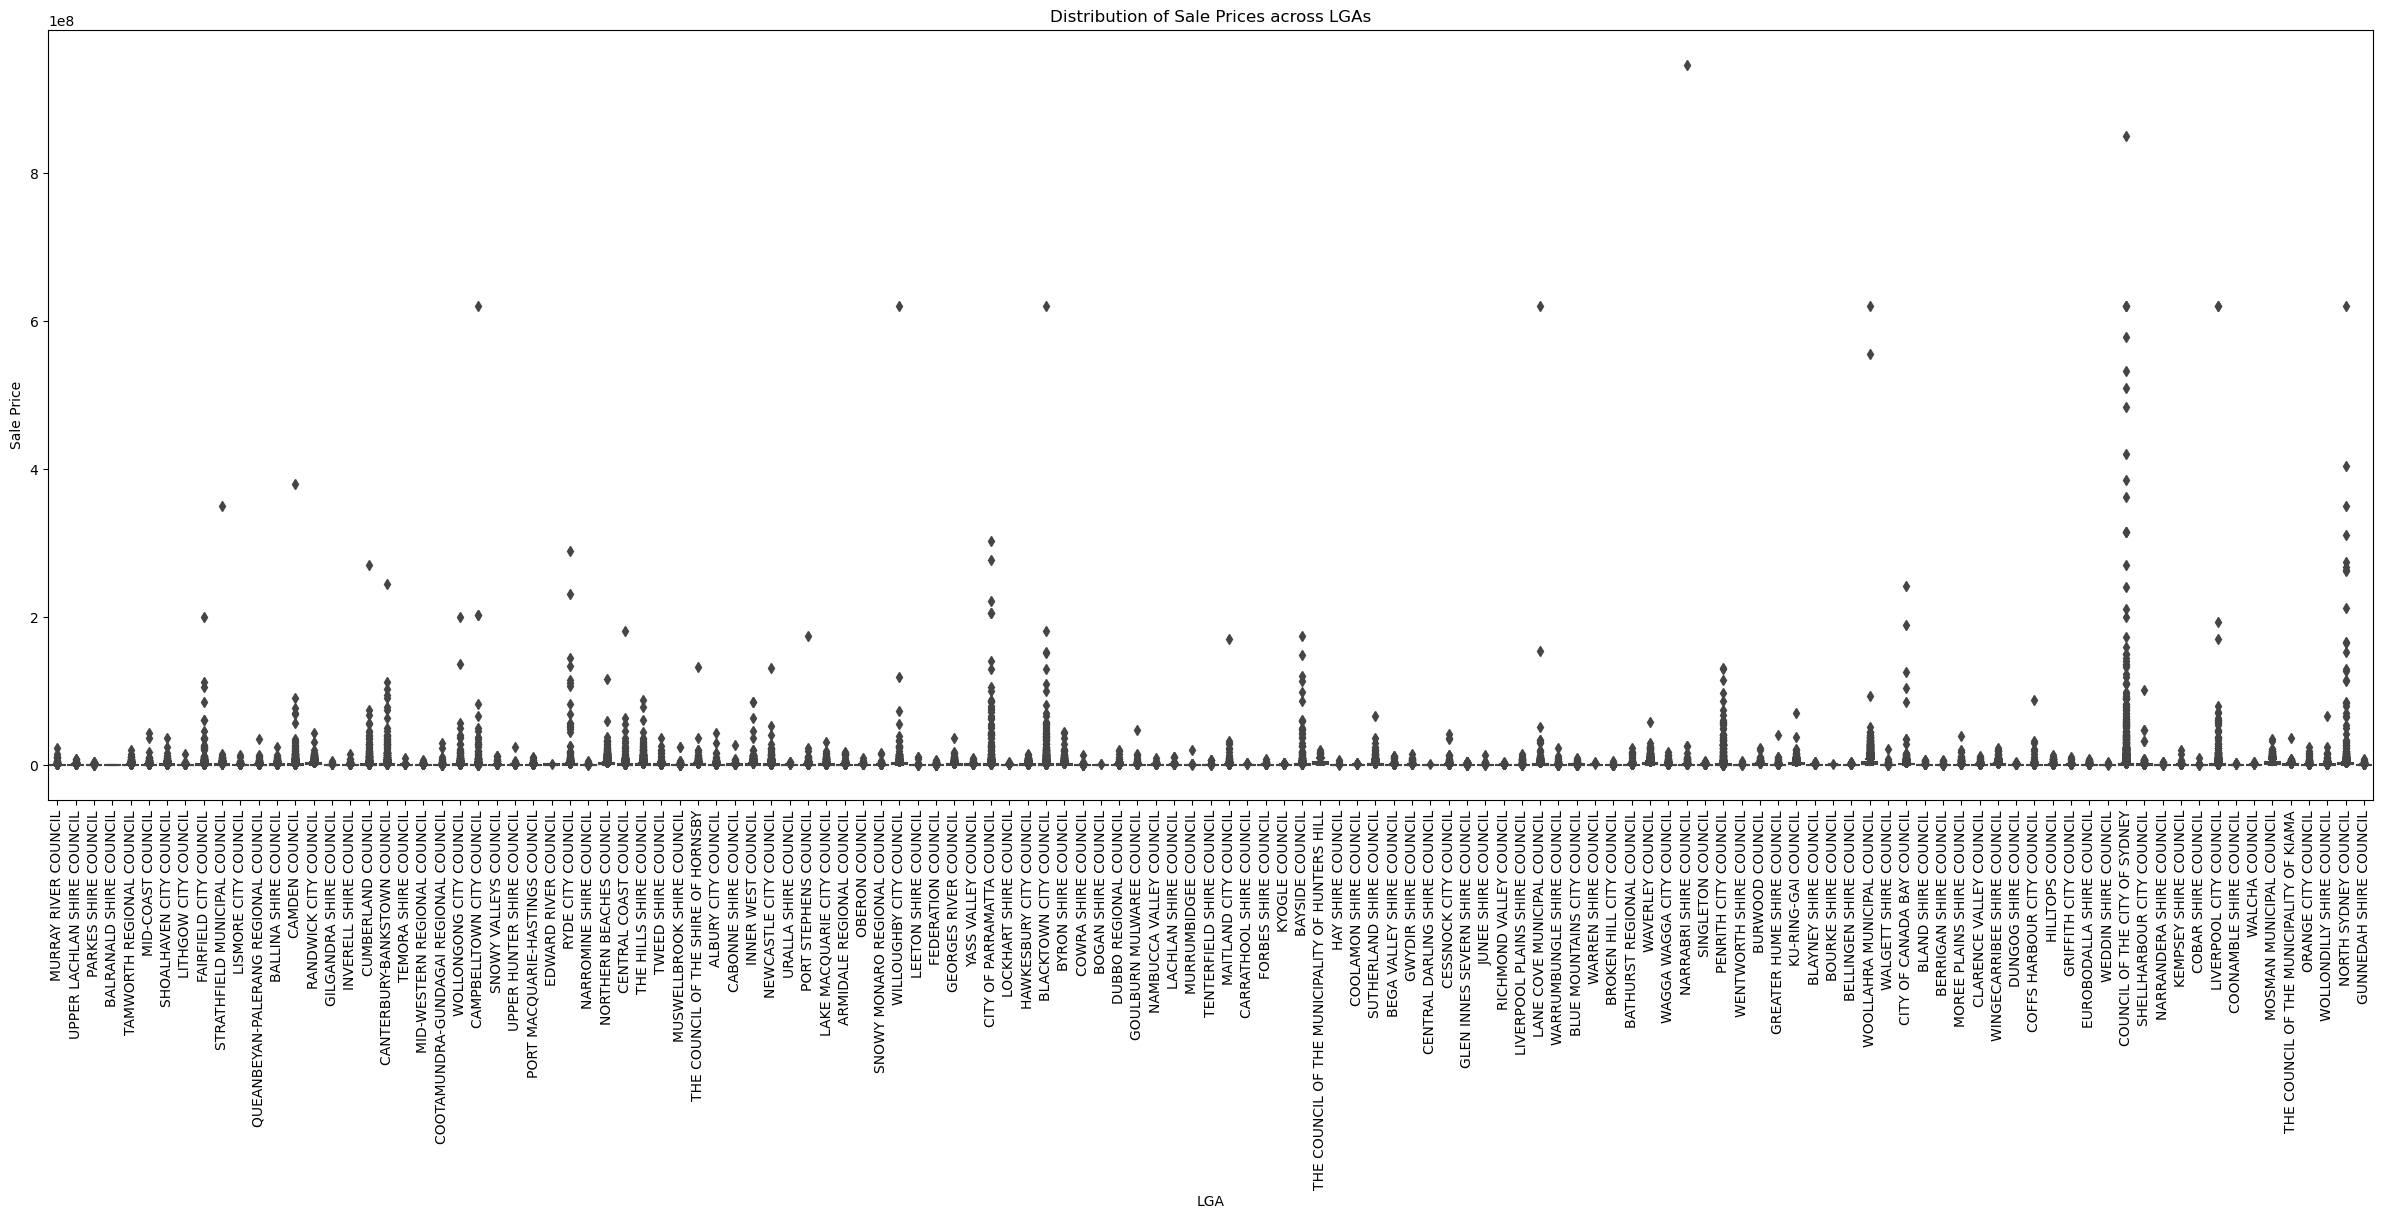

In [18]:
plt.figure(figsize=(30, 10))
sns.boxplot(x='LGA', y='Sale Price', data=df)
plt.xlabel('LGA')
plt.ylabel('Sale Price')
plt.title('Distribution of Sale Prices across LGAs')
plt.xticks(rotation=90)
plt.show()

Filtering to values below $5M to minimise outliers

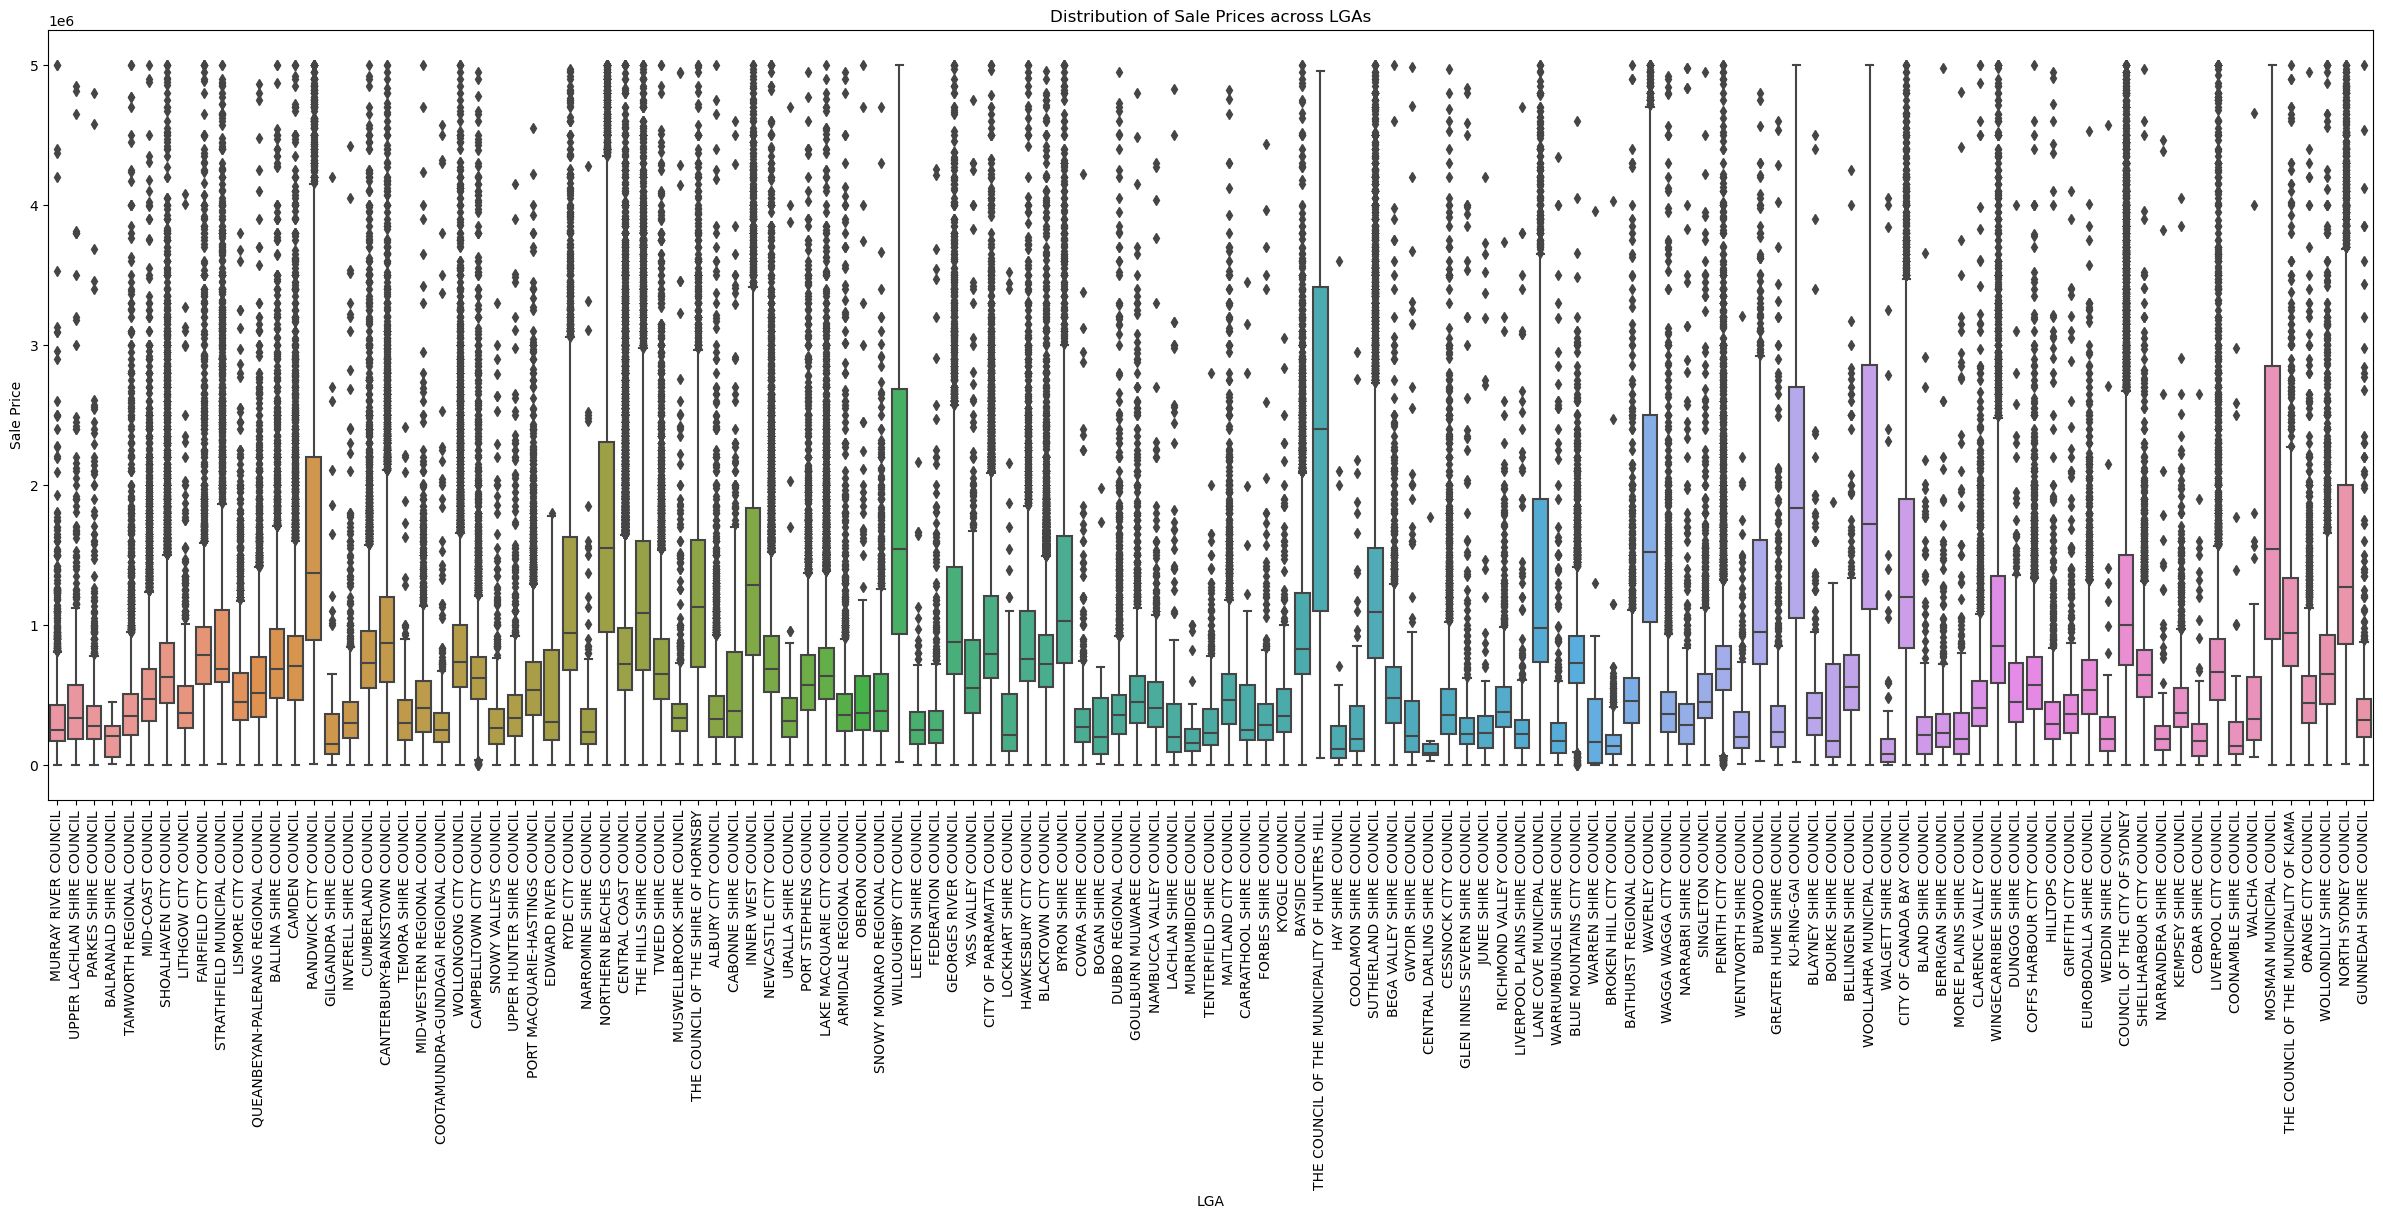

In [21]:
df_lessthan5M = df[df['Sale Price'] <= 5000000]

plt.figure(figsize=(30, 10))
sns.boxplot(x='LGA', y='Sale Price', data=df_lessthan5M)
plt.xlabel('LGA')
plt.ylabel('Sale Price')
plt.title('Distribution of Sale Prices across LGAs')
plt.xticks(rotation=90)
plt.show()

Narrowing down results to sales in the past 365 days (01/07/2022 - 01/07/2023)

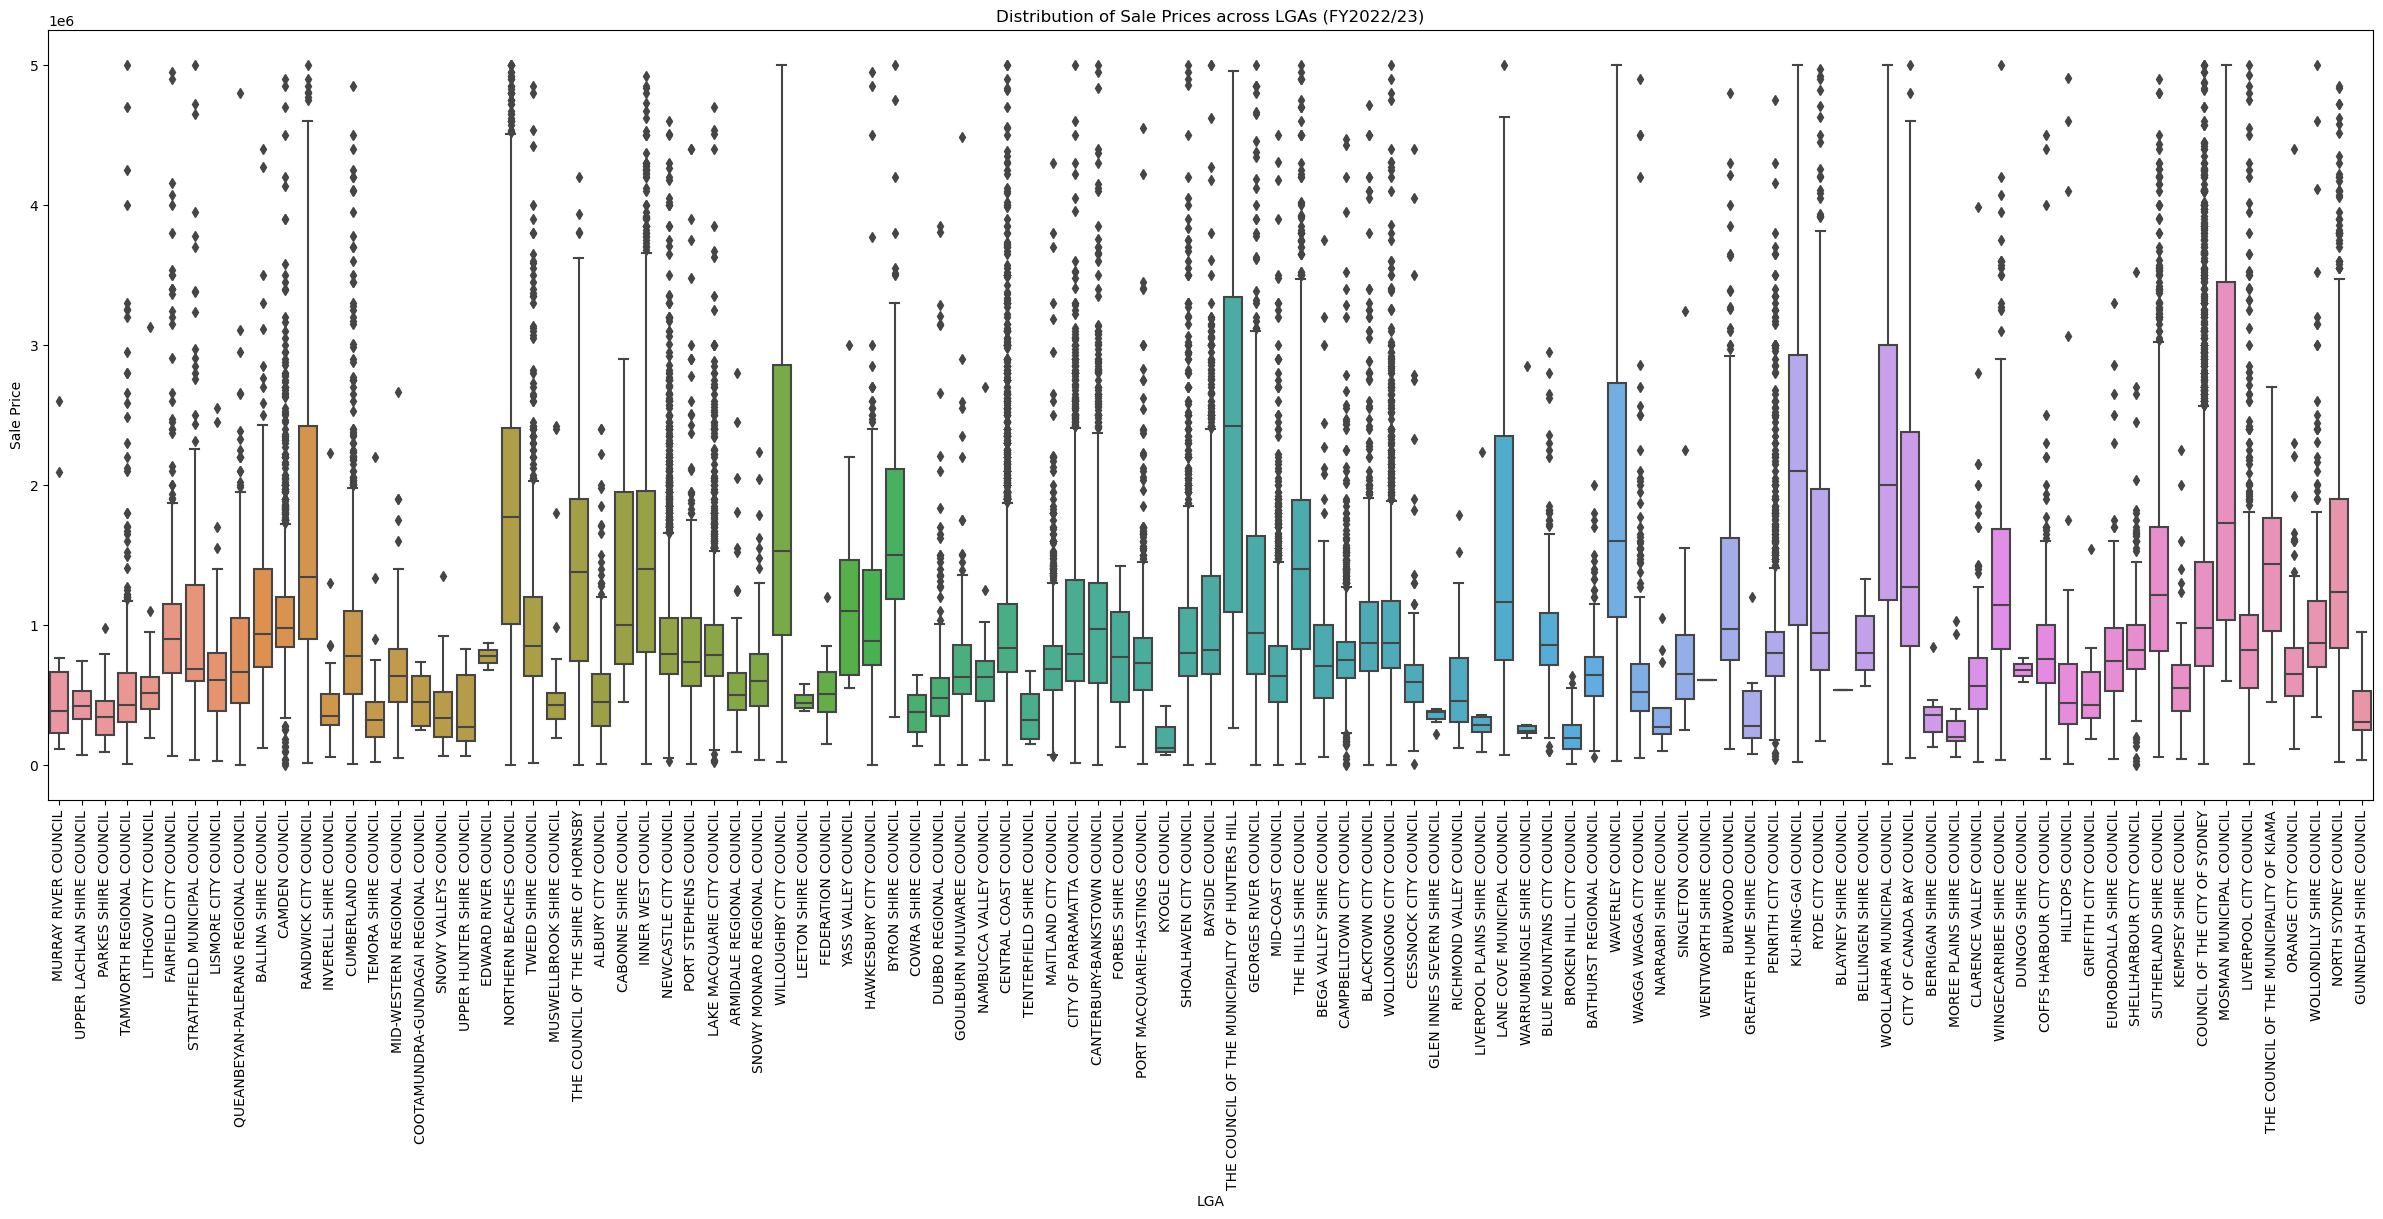

In [38]:
# Filter the DataFrame for sales in the past year
one_year_ago = datetime.now() - timedelta(days=365)
df_oneYearAgo_lessthan5M = df_lessthan5M[df_lessthan5M['Sale Date'] >= one_year_ago]

plt.figure(figsize=(30, 10))
sns.boxplot(x='LGA', y='Sale Price', data=df_oneYearAgo_lessthan5M)
plt.xlabel('LGA')
plt.ylabel('Sale Price')
plt.title('Distribution of Sale Prices across LGAs (FY2022/23)')
plt.xticks(rotation=90)
plt.show()

#### Discussion

* Wealthier LGAs often have greater interquartile ranges, whereas poorer LGAs have tight bands
* The majority of LGAs still have their sale price averages below $1M
* The lack of outliers below the interquartile range shows how tight the housing market is; there is no room to catch a bargain

### Distribution plots

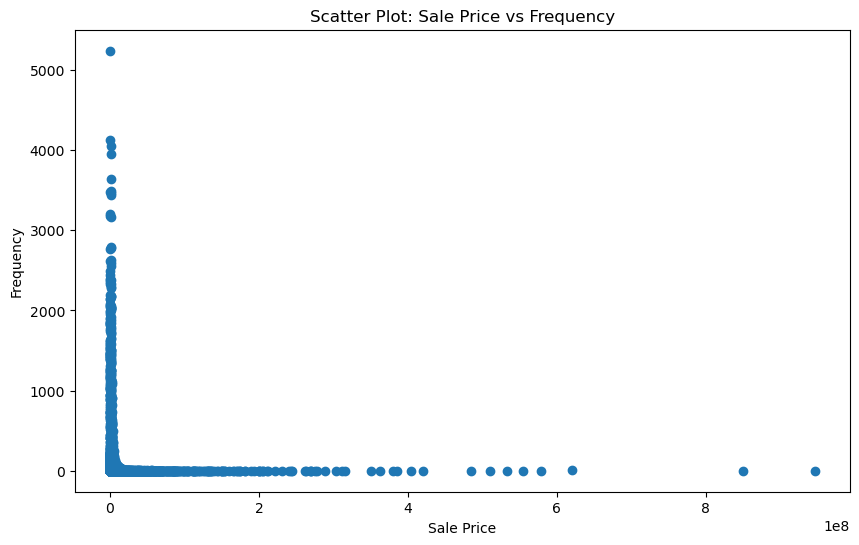

In [11]:
# Calculate the frequency of each sales price value
sales_price_counts = df['Sale Price'].value_counts()

# Extract the sales prices and their frequencies
sales_prices = sales_price_counts.index
frequencies = sales_price_counts.values

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sales_prices, frequencies)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Scatter Plot: Sale Price vs Frequency')
plt.show()

I'll need to filter the data so that the sales on the far right hand side of the above scatter plot do not heavily skew my graphs. I'll filter the results to only include sales of $10M or less as the scatter plot visually looks more interesting and is of greater relevance to normal home buyers (like myself).

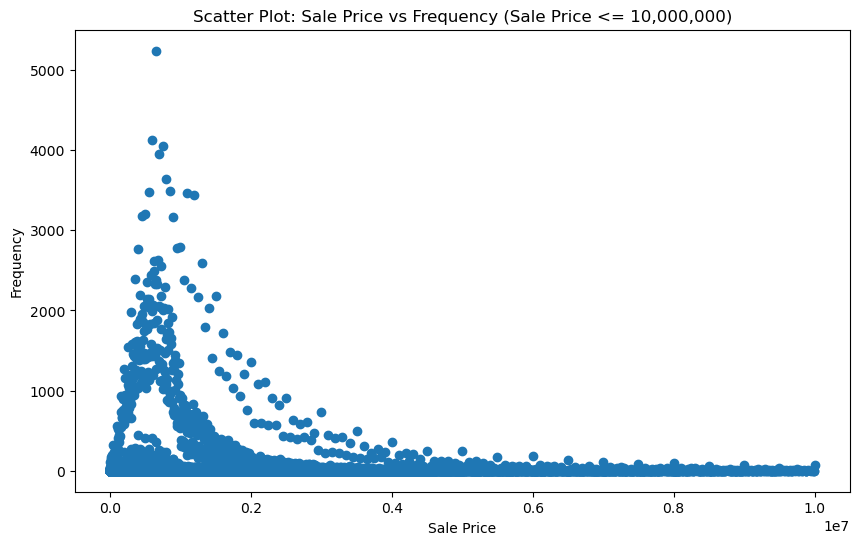

In [22]:
# Filter the DataFrame based on the sale price condition
df_lessthan10M = df[df['Sale Price'] <= 10000000]

# Calculate the frequency of each sales price value in the filtered DataFrame
sales_price_counts = df_lessthan10M['Sale Price'].value_counts()

# Extract the sales prices and their frequencies
sales_prices = sales_price_counts.index
frequencies = sales_price_counts.values

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sales_prices, frequencies)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Scatter Plot: Sale Price vs Frequency (Sale Price <= 10,000,000)')
plt.show()

Now to plot a histogram, I will further narrow down analysis to sales upto $4M as this visually seems to be the point where there is no variation in the frequency of sales occuring at price points beyond $4M. This gives us a much more meaningful histogram below.

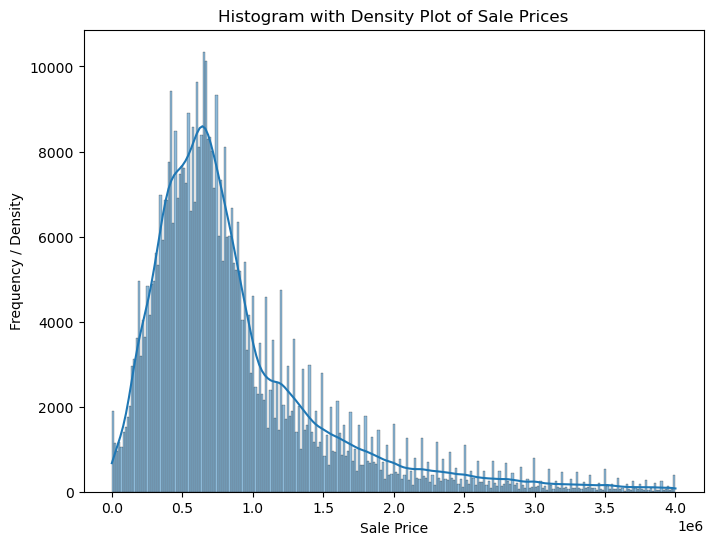

In [23]:
df_lessthan4M = df[df['Sale Price'] <= 4000000]

plt.figure(figsize=(8, 6))
sns.histplot(df_lessthan4M['Sale Price'], kde=True)
plt.xlabel('Sale Price')
plt.ylabel('Frequency / Density')
plt.title('Histogram with Density Plot of Sale Prices')
plt.show()


Now to plot the differences from 2018 to 2023

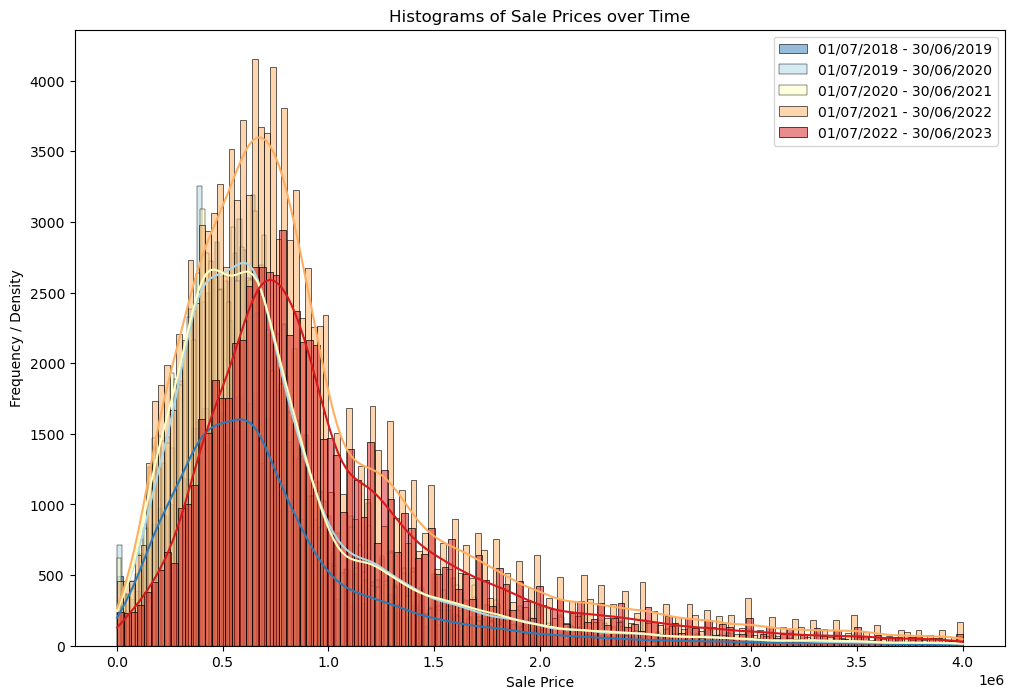

In [37]:
# Define the time periods with date ranges
time_periods = [
    '01/07/2018 - 30/06/2019',
    '01/07/2019 - 30/06/2020',
    '01/07/2020 - 30/06/2021',
    '01/07/2021 - 30/06/2022',
    '01/07/2022 - 30/06/2023'
]

colours = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']

# Create a list to store the filtered data for each time period
filtered_data_list_histogram = []

# Iterate over time periods
for i, time_period in enumerate(time_periods):
    # Extract start and end dates
    start_date = pd.to_datetime('01/07/2018') + pd.DateOffset(years=i)
    end_date = start_date + pd.DateOffset(years=1) - pd.DateOffset(days=1)
    
    # Filter the data for the specific time period
    filtered_data = df_lessthan4M[(df_lessthan4M['Sale Date'] >= start_date) & (df_lessthan4M['Sale Date'] <= end_date)]
    
    filtered_data_list_histogram.append(filtered_data)

# Create the overlaid histograms
plt.figure(figsize=(12, 8))
for i, filtered_data in enumerate(filtered_data_list_histogram):
    sns.histplot(filtered_data['Sale Price'], label=time_periods[i], kde=True, alpha=0.5, color=colours[i])

plt.xlabel('Sale Price')
plt.ylabel('Frequency / Density')
plt.title('Histograms of Sale Prices over Time')
plt.legend()
plt.show()


Remember that the height of this plot is the frequency of sales.

#### Discussion

* $700k seems to be the average in the NSW market
* Demand for property beyond $2M seems to plateau. At this point, price is no longer an indication of demand, but rather of the intrinsic value of the home to the buyer (or at least this is how I interpret it)
* Average prices began to rise dramatically in FY2021/22 and continued to rise into FY2022/23
* Volume of sales rose from FY2018/19 to FY2019/20 dramatically, bascially stayed the same in the following year, then peaked in FY2021/22, and finally cooled down in FY2022/23 to similar levels in previous years.
* Therefore, despite the market cooling down in 2022/23, prices continued to rise. This must be explained by a lack of supply.